In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u
from copy import deepcopy

from R_load import R_val

from multiprocessing import Pool
import emcee


corrections = np.loadtxt('ps1_calspec_cor.txt')
calsources = pd.read_csv('../calibration/calspec_full.csv')

In [3]:
ps1 = np.load('cal_mags/caspec_mags_ps1.npy',allow_pickle=True).item()
ps1 = pd.DataFrame(ps1)

good = []
for i in range(len(ps1['name'])):
    if 'ngc6681' not in ps1['name'].iloc[i]:
        good += [i]
good = np.array(good)
ps1 = ps1.iloc[good]
gr = ps1['ps1g'].values-ps1['ps1r'].values
ind = (gr < 1) #& (gr >= 0.2)
ps1 = ps1.iloc[ind]

In [4]:
decam = np.load('cal_mags/caspec_mags_decam.npy',allow_pickle=True).item()
decam = pd.DataFrame(decam)

good = []
for i in range(len(decam['name'])):
    if 'ngc6681' not in decam['name'].iloc[i]:
        good += [i]
good = np.array(good)
decam = decam.iloc[good]
ind = (gr < 1) #& (gr >= 0.2)
decam = decam.iloc[ind]

<IPython.core.display.Javascript object>


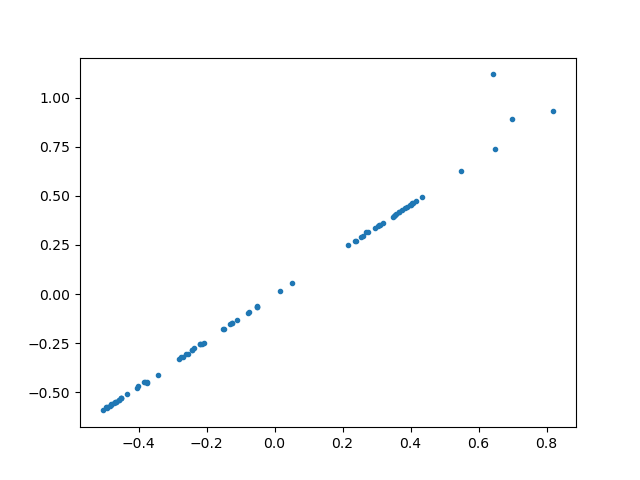

In [9]:
pgr = ps1['ps1g'].values-ps1['ps1r'].values
dgr = decam['DECam.g'].values-decam['DECam.r'].values
plt.figure()
plt.plot(pgr,dgr,'.')

In [209]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux
    

def filt_comp(c,ps1mag,R_ref=0,ext=0,R_var=False):
    zp = 25
    gr = ext*(ps1mag['ps1g'] - ps1mag['ps1r'])
    if R_var:
        ge = ext * R_val('ps1g',gr=gr,ext=ext)[0]
        re = ext * R_val('ps1r',gr=gr,ext=ext)[0]
        ie = ext * R_val('ps1i',gr=gr,ext=ext)[0]
        ze = ext * R_val('ps1z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 #
        ye = 0 
    g = mag2flux(ps1mag['ps1g']-ge,zp)
    r = mag2flux(ps1mag['ps1r']-re,zp)
    i = mag2flux(ps1mag['ps1i']-ie,zp)
    z = mag2flux(ps1mag['ps1z']-ze,zp)
    y = mag2flux(ps1mag['ps1y']-ye,zp)
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z)*(g/r)**c[4]
    filt = -2.5*np.log10(fit) + 25 + R_ref*ext
    return filt


def z_comp(c,ps1mag,R_ref=0,ext=0,R_var=False):
    zp = 25
    gr = ext*(ps1mag['ps1g'] - ps1mag['ps1r'])
    if R_var:
        ge = ext * R_val('ps1g',gr=gr,ext=ext)[0]
        re = ext * R_val('ps1r',gr=gr,ext=ext)[0]
        ie = ext * R_val('ps1i',gr=gr,ext=ext)[0]
        ze = ext * R_val('ps1z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 #
        ye = 0 
    g = mag2flux(ps1mag['ps1g']-ge,zp)
    r = mag2flux(ps1mag['ps1r']-re,zp)
    i = mag2flux(ps1mag['ps1i']-ie,zp)
    z = mag2flux(ps1mag['ps1z']-ze,zp)
    y = mag2flux(ps1mag['ps1y']-ye,zp)
    fit = (c[0]*z + c[1]*y)*(g/i)**c[2]
    filt = -2.5*np.log10(fit) + 25 + R_ref*ext
    return filt

def z_minimizer(c,ps1mag,refmag,ext=0):
    fit = z_comp(c,ps1mag,ext=ext)
    diff = abs(refmag-fit)
    res = np.nansum(diff)
    return res


def filt_minimizer(c,ps1mag,refmag,ext=0):
    fit = filt_comp(c,ps1mag,ext=ext)
    diff = abs(refmag-fit)
    res = np.nansum(diff)
    return res


def g_comp(c,ps1mag,R_ref=0,ext=0,R_var=False):
    zp = 25
    gr = ext*(ps1mag['ps1g'] - ps1mag['ps1r'])
    if R_var:
        ge = ext * R_val('ps1g',gr=gr,ext=ext)[0]
        re = ext * R_val('ps1r',gr=gr,ext=ext)[0]
        ie = ext * R_val('ps1i',gr=gr,ext=ext)[0]
        ze = ext * R_val('ps1z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 #
        ye = 0 
    g = mag2flux(ps1mag['ps1g']-ge,zp)
    r = mag2flux(ps1mag['ps1r']-re,zp)
    i = mag2flux(ps1mag['ps1i']-ie,zp)
    z = mag2flux(ps1mag['ps1z']-ze,zp)
    y = mag2flux(ps1mag['ps1y']-ye,zp)
    fit = (c[0]*g)*(g/i)**c[1]
    filt = -2.5*np.log10(fit) + 25 + R_ref*ext
    return filt

def g_minimizer(c,ps1mag,refmag,ext=0):
    fit = g_comp(c,ps1mag,ext=ext)
    diff = abs(refmag-fit)
    res = np.nansum(diff)
    return res


def r_comp(c,ps1mag,R_ref=0,ext=0,R_var=False):
    zp = 25
    gr = ext*(ps1mag['ps1g'] - ps1mag['ps1r'])
    if R_var:
        ge = ext * R_val('ps1g',gr=gr,ext=ext)[0]
        re = ext * R_val('ps1r',gr=gr,ext=ext)[0]
        ie = ext * R_val('ps1i',gr=gr,ext=ext)[0]
        ze = ext * R_val('ps1z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 #
        ye = 0 
    g = mag2flux(ps1mag['ps1g']-ge,zp)
    r = mag2flux(ps1mag['ps1r']-re,zp)
    i = mag2flux(ps1mag['ps1i']-ie,zp)
    z = mag2flux(ps1mag['ps1z']-ze,zp)
    y = mag2flux(ps1mag['ps1y']-ye,zp)
    fit = (c[0]*r)*(g/i)**c[1]
    filt = -2.5*np.log10(fit) + 25 + R_ref*ext
    return filt

def r_minimizer(c,ps1mag,refmag,ext=0):
    fit = r_comp(c,ps1mag,ext=ext)
    diff = abs(refmag-fit)
    res = np.nansum(diff)
    return res

def i_comp(c,ps1mag,R_ref=0,ext=0,R_var=False):
    zp = 25
    gr = ext*(ps1mag['ps1g'] - ps1mag['ps1r'])
    if R_var:
        ge = ext * R_val('ps1g',gr=gr,ext=ext)[0]
        re = ext * R_val('ps1r',gr=gr,ext=ext)[0]
        ie = ext * R_val('ps1i',gr=gr,ext=ext)[0]
        ze = ext * R_val('ps1z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 #
        ye = 0 
    g = mag2flux(ps1mag['ps1g']-ge,zp)
    r = mag2flux(ps1mag['ps1r']-re,zp)
    i = mag2flux(ps1mag['ps1i']-ie,zp)
    z = mag2flux(ps1mag['ps1z']-ze,zp)
    y = mag2flux(ps1mag['ps1y']-ye,zp)
    fit = (c[0]*i)*(g/i)**c[1]
    filt = -2.5*np.log10(fit) + 25 + R_ref*ext
    return filt

def i_minimizer(c,ps1mag,refmag,ext=0):
    fit = i_comp(c,ps1mag,ext=ext)
    diff = abs(refmag-fit)
    res = np.nansum(diff)
    return res


# emcee

def chi2(var,data,ex=0):
    real = mag2flux(data['r'])
    fit = r_comp(var,data,ext=ex)
    fit = mag2flux(fit)
    fit = np.log(fit)
    real = np.log(real)
    residual = np.nansum(((fit-real)**2/real))
    return -(residual) 

def flat_prior(var):
    g = var[0]
    i = var[1]
    z = var[2]
    colour = var[3]
    if (0 <= g) & (0 <= i) & (0 <= z) & ((g+i+z) < 1):
        #print(g+i+z)
        return 0.0
    return -np.inf

def probability(var, data,ex=0):
    lp = flat_prior(var)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2(var,data,ex=ex)

In [98]:
c0 = [0.1,0.1,0.1,0.1,0]
bds = [(0,2),(0,2),(0,2),(0,2),(-100,100)]
res = minimize(filt_minimizer,c0,args=(ps1,decam['DECam.g'].values),bounds=bds)

/Users/rridden/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rridden/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [99]:
res

      fun: 0.8759697914705171
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([26.09572061, 30.56681452, 31.88636699, 35.97835878, -5.52214431])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 666
      nit: 34
     njev: 111
   status: 0
  success: True
        x: array([0.        , 0.39672769, 0.56637477, 0.01308544, 0.85050062])

In [117]:
len(filts)

6

<IPython.core.display.Javascript object>


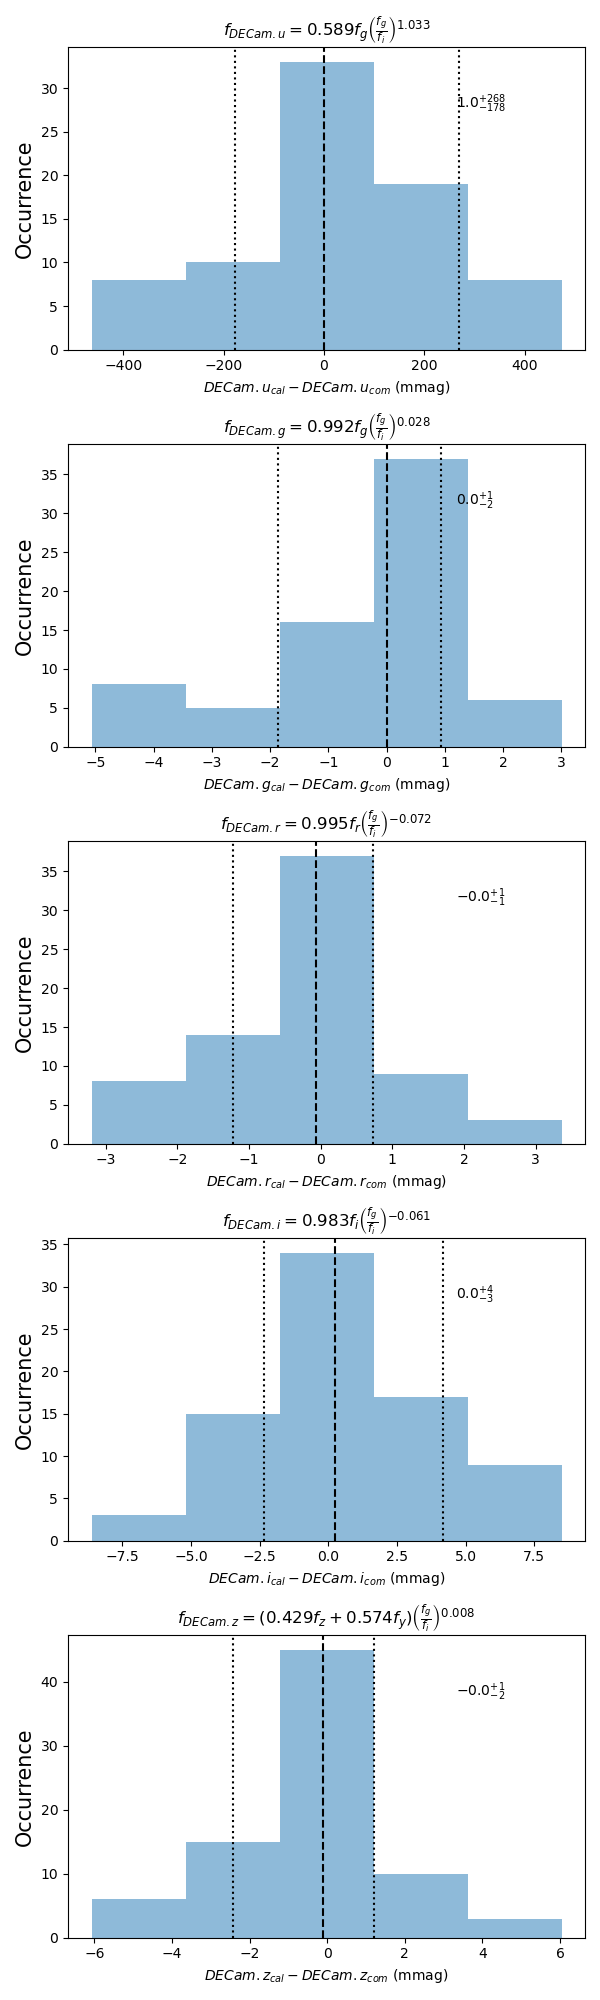

[0.58906083 1.03347526]
[0.99169699 0.02816213]
[ 0.99468739 -0.07174337]
[ 0.98325917 -0.06073959]
[0.42938712 0.57355253 0.00767245]


In [215]:

filts = list(decam.keys())[:-1]
plt.figure(figsize=(6,20))

for i in range(len(filts)):
    filt = filts[i]
    c0 = [0.5,0]
    bds = [(0,2),(-100,100)]
    if (filt == 'DECam.g') | (filt == 'DECam.u'):
        res = minimize(g_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)
        test = g_comp(res.x,ps1)
        s = r'$f_{%(band)s} = %(cg)s f_g\left(\frac{f_g}{f_i}\right)^{%(cp)s}$'
        s = s % {'band':filt,'cg':str(np.round(res.x[0],3)),'cp':str(np.round(res.x[1],3))}
    elif (filt == 'DECam.r'):
        res = minimize(r_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)
        test = r_comp(res.x,ps1)
        s = r'$f_{%(band)s} = %(cg)s f_r\left(\frac{f_g}{f_i}\right)^{%(cp)s}$'
        s = s % {'band':filt,'cg':str(np.round(res.x[0],3)),'cp':str(np.round(res.x[1],3))}
    elif (filt == 'DECam.i'):
        res = minimize(i_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)
        test = i_comp(res.x,ps1)
        s = r'$f_{%(band)s} = %(cg)s f_i\left(\frac{f_g}{f_i}\right)^{%(cp)s}$'
        s = s % {'band':filt,'cg':str(np.round(res.x[0],3)),'cp':str(np.round(res.x[1],3))}
    elif (filt == 'DECam.z'):
        c0 = [0.5,0.5,0]
        bds = [(0,2),(0,2),(-100,100)]
        res = minimize(z_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)
        test = z_comp(res.x,ps1)
        s = r'$f_{%(band)s} = (%(cg)s f_z + %(cy)s f_y)\left(\frac{f_g}{f_i}\right)^{%(cp)s}$'
        s = s % {'band':filt,'cg':str(np.round(res.x[0],3)),'cy':str(np.round(res.x[1],3)),'cp':str(np.round(res.x[2],3))}
    print(res.x)
    diff = decam[filt]-test
    gr = ps1['ps1g'].values-ps1['ps1r'].values
    ri = ps1['ps1r'].values-ps1['ps1i'].values

    mask = ~sigma_clip(diff).mask
    diff = diff[mask]


    plt.subplot(5,1,i+1)
    b = int(np.nanmax(diff) - np.nanmin(diff) /(2*iqr(diff)*len(diff)**(-1/3)))
    plt.hist(diff*1e3,bins=5,alpha=0.5)
    #plt.hist(control[mask]*1e3)
    #plt.hist(kdiff[ind],bins=10)
    med = np.percentile(diff*1e3,50)
    low = np.percentile(diff*1e3,16)
    high = np.percentile(diff*1e3,84)
    plt.axvline(med,ls='--',color='k')
    plt.axvline(low,ls=':',color='k')
    plt.axvline(high,ls=':',color='k')

    
    plt.title(s)

    s = '$'+str((np.round(med,0)))+'^{+' + str(int(np.round(high-med,0)))+'}_{'+str(int(np.round(low-med,0)))+'}$'
    plt.annotate(s,(.75,.8),fontsize=10,xycoords='axes fraction')
    plt.xlabel(r'$%(band)s_{cal}-%(band)s_{com}$ (mmag)' % {'band':filt})

    plt.ylabel('Occurrence',fontsize=15)
    #plt.savefig('PS1_com_r_res.pdf', bbox_inches = "tight")
plt.tight_layout()
plt.savefig('DECam_comp.pdf')

<IPython.core.display.Javascript object>


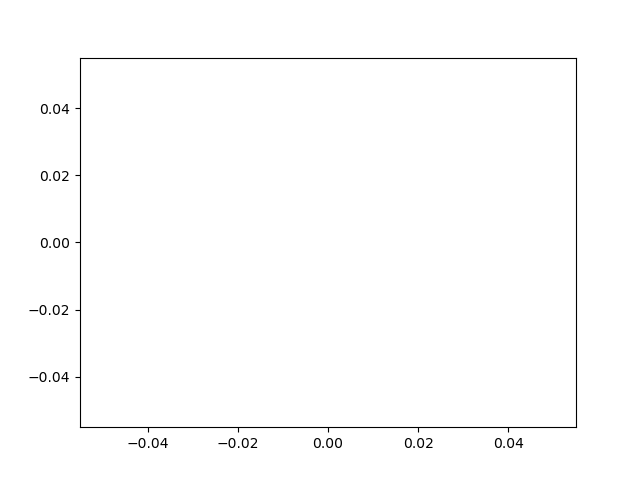

[]

In [206]:
plt.figure()
plt.plot()

In [162]:
res.x

array([ 0.96527654, -0.13564127])

In [179]:
filt = filts[-1]
c0 = [0.5,0.5,0]
bds = [(0,2),(0,2),(-100,100)]

print(filt)
res = minimize(g_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)

test = z_comp(res.x,ps1)
#test = r_comp(mc,syn)
diff = decam[filt]-test
gr = ps1['ps1g'].values-ps1['ps1r'].values
ri = ps1['ps1r'].values-ps1['ps1i'].values

mask = ~sigma_clip(diff).mask
diff = diff[mask]

DECam.z


<IPython.core.display.Javascript object>


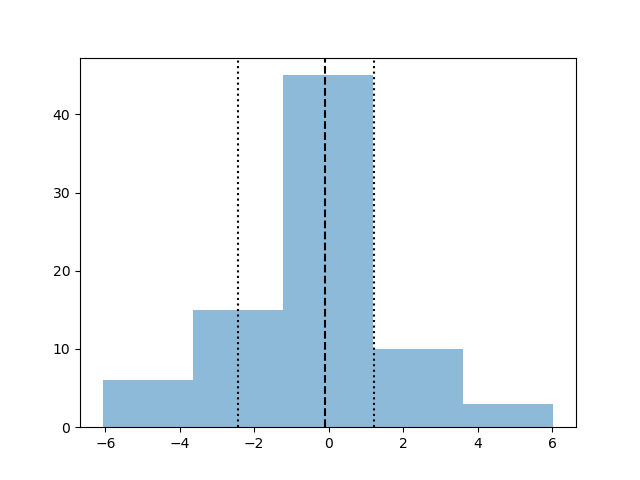

In [180]:
plt.figure()
b = int(np.nanmax(diff) - np.nanmin(diff) /(2*iqr(diff)*len(diff)**(-1/3)))
plt.hist(diff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(diff*1e3,50)
low = np.percentile(diff*1e3,16)
high = np.percentile(diff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

In [181]:
res.x

array([0.42938712, 0.57355253, 0.00767245])

In [199]:
filt = filts[0]
c0 = [0.1,0.5]
bds = [(0,2),(-100,100)]

print(filt)
res = minimize(g_minimizer,c0,args=(ps1,decam[filt].values),bounds=bds)

test = g_comp(res.x,ps1)
#test = r_comp(mc,syn)
diff = decam[filt]-test
gr = ps1['ps1g'].values-ps1['ps1r'].values
ri = ps1['ps1r'].values-ps1['ps1i'].values

mask = ~sigma_clip(diff).mask
diff = diff[mask]

DECam.u


<IPython.core.display.Javascript object>


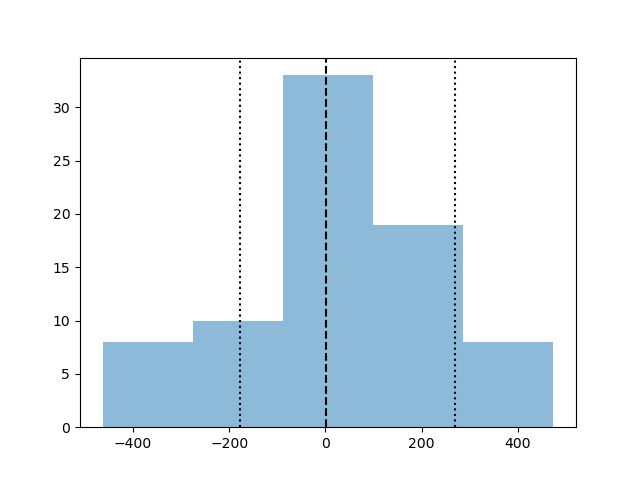

In [200]:
plt.figure()
b = int(np.nanmax(diff) - np.nanmin(diff) /(2*iqr(diff)*len(diff)**(-1/3)))
plt.hist(diff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(diff*1e3,50)
low = np.percentile(diff*1e3,16)
high = np.percentile(diff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

In [202]:
res.x

array([0.5889963 , 1.03324243])